In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mikeio

num_sensors = 5
lags = 52
ds = mikeio.read("Data/Area.dfsu",time=slice("2022-01-01", "2022-04-30"), items=[0])
ds.to_dfs("Data/Area_5m.dfsu")
load_X = ds[0].to_numpy()
load_X.shape
n = load_X.shape[0]
m = load_X.shape[1]
val_lengths = 20

### Select indices for training, validation, and testing
train_indices = np.arange(0, int(n*0.85))
valid_indices = np.arange(int(n*0.85), int(n*0.85) + val_lengths)
test_indices = np.arange(int(n*0.85) + val_lengths, n - lags)

In [6]:
np.load("ForecastingResults/sensor_locations.npy")

array([3179, 1119, 1289,  207, 2288], dtype=int32)

In [2]:
scaled_forecast = np.load('ForecastingResults/reconstructions.npy')
truths = np.load('ForecastingResults/truth.npy')
sensor_locations = np.load('ForecastingResults/sensor_locations.npy')

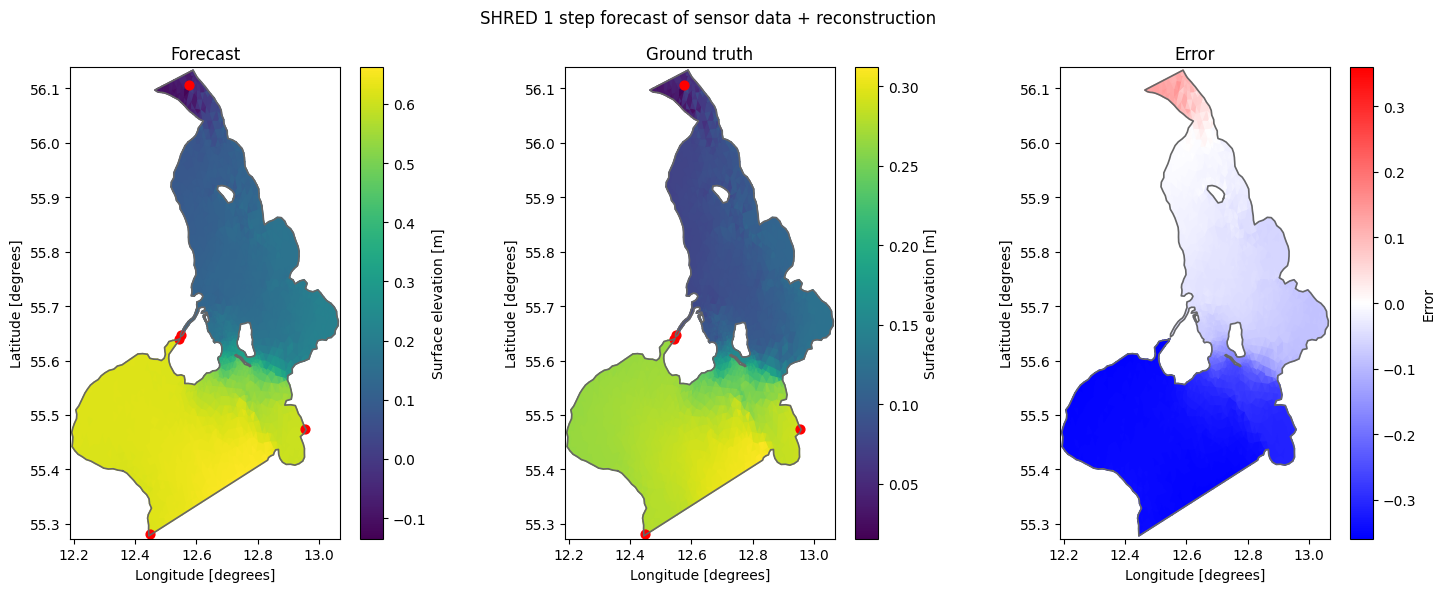

In [3]:
elem_cor = ds[0].geometry.element_coordinates
plot_index = 10


# Create dataarrays for plotting
da_plot_recon = ds[0].sel(time=ds.time[test_indices[plot_index]+ lags]).copy()
da_plot_true = da_plot_recon.copy()
da_plot_err = da_plot_recon.copy()
# Fill with values from the reconstruction and the ground truth, as well as errors
da_plot_recon.values = scaled_forecast[plot_index]
da_plot_true.values = truths[plot_index]
da_plot_err.values =  truths[plot_index]-scaled_forecast[plot_index]
# min and max values for the colorbar
vmin = -max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))
vmax = max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))

fig,axs = plt.subplots(1,3,figsize=(15,6))
fig.suptitle('SHRED 1 step forecast of sensor data + reconstruction')

da_plot_true.plot(ax = axs[1],add_colorbar=False)
cbar = fig.colorbar(axs[1].collections[0], ax=axs[1],label='Surface elevation [m]')
axs[1].set_title('Ground truth')

da_plot_err.plot(ax = axs[2],cmap="bwr",vmin=vmin,vmax=vmax,add_colorbar=False)
cbar = fig.colorbar(axs[2].collections[0], ax=axs[2],label='Error')
axs[2].set_title('Error')

da_plot_recon.plot(ax = axs[0],add_colorbar=False)
cbar = fig.colorbar(axs[0].collections[0], ax=axs[0],label='Surface elevation [m]')
axs[0].set_title('Forecast')

# Add a red dot to the spatial points indicated by the sensor locations
for i in range(num_sensors):
    axs[0].scatter(elem_cor[sensor_locations[i],0], elem_cor[sensor_locations[i],1], color='red', s=40, label='Sensor location')
    axs[1].scatter(elem_cor[sensor_locations[i],0], elem_cor[sensor_locations[i],1], color='red', s=40, label='Sensor location')

plt.tight_layout()

In [4]:
rmspe = np.sqrt(np.mean(np.square((da_plot_err.values / da_plot_true.values)), axis=0))
rmse = np.sqrt(np.mean(np.square((da_plot_err.values)), axis=0))

print('RMSPE: ', rmspe,' \nRMSE:  ', rmse)

RMSPE:  1.0912831  
RMSE:   0.22715831
